In [1]:
# import libaries 1

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import SimpleITK as sitk
import radiomics 
import six,numpy as np
import os
import csv
import pandas as pd
import seaborn as sn
import pylab as pl
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
import glmnet_python
import imblearn
import math
import scipy.stats

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in

In [2]:
# import libraries 2

from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.feature_selection import GenericUnivariateSelect, VarianceThreshold, mutual_info_classif, SelectFromModel, SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, ridge_regression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, OrthogonalMatchingPursuit, MultiTaskLasso, LassoLars, Lars, RidgeCV, ElasticNet, ElasticNetCV, LogisticRegression, LassoLarsCV, LassoCV, LinearRegression, Ridge, Lasso, lasso_path, enet_path
from sklearn.model_selection import LeaveOneOut, cross_validate, cross_val_predict, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC, SVR, NuSVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn import linear_model
from sklearn.utils import resample
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from radiomics import featureextractor,imageoperations
from pandas import Series, DataFrame 

from scipy import stats

from glmnet import glmnet
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
# Import csv files 

file = '/Users/hwang/research/1_MM/pyradiomics/scikit_radiomics_T1norm_ISS_20191122_MWU.csv'
data = pd.read_csv(file)
target = data['Class']
target = target.astype(np.float64)
feature = data.loc[:,data.columns != 'Class']
reader = csv.DictReader(open(file))

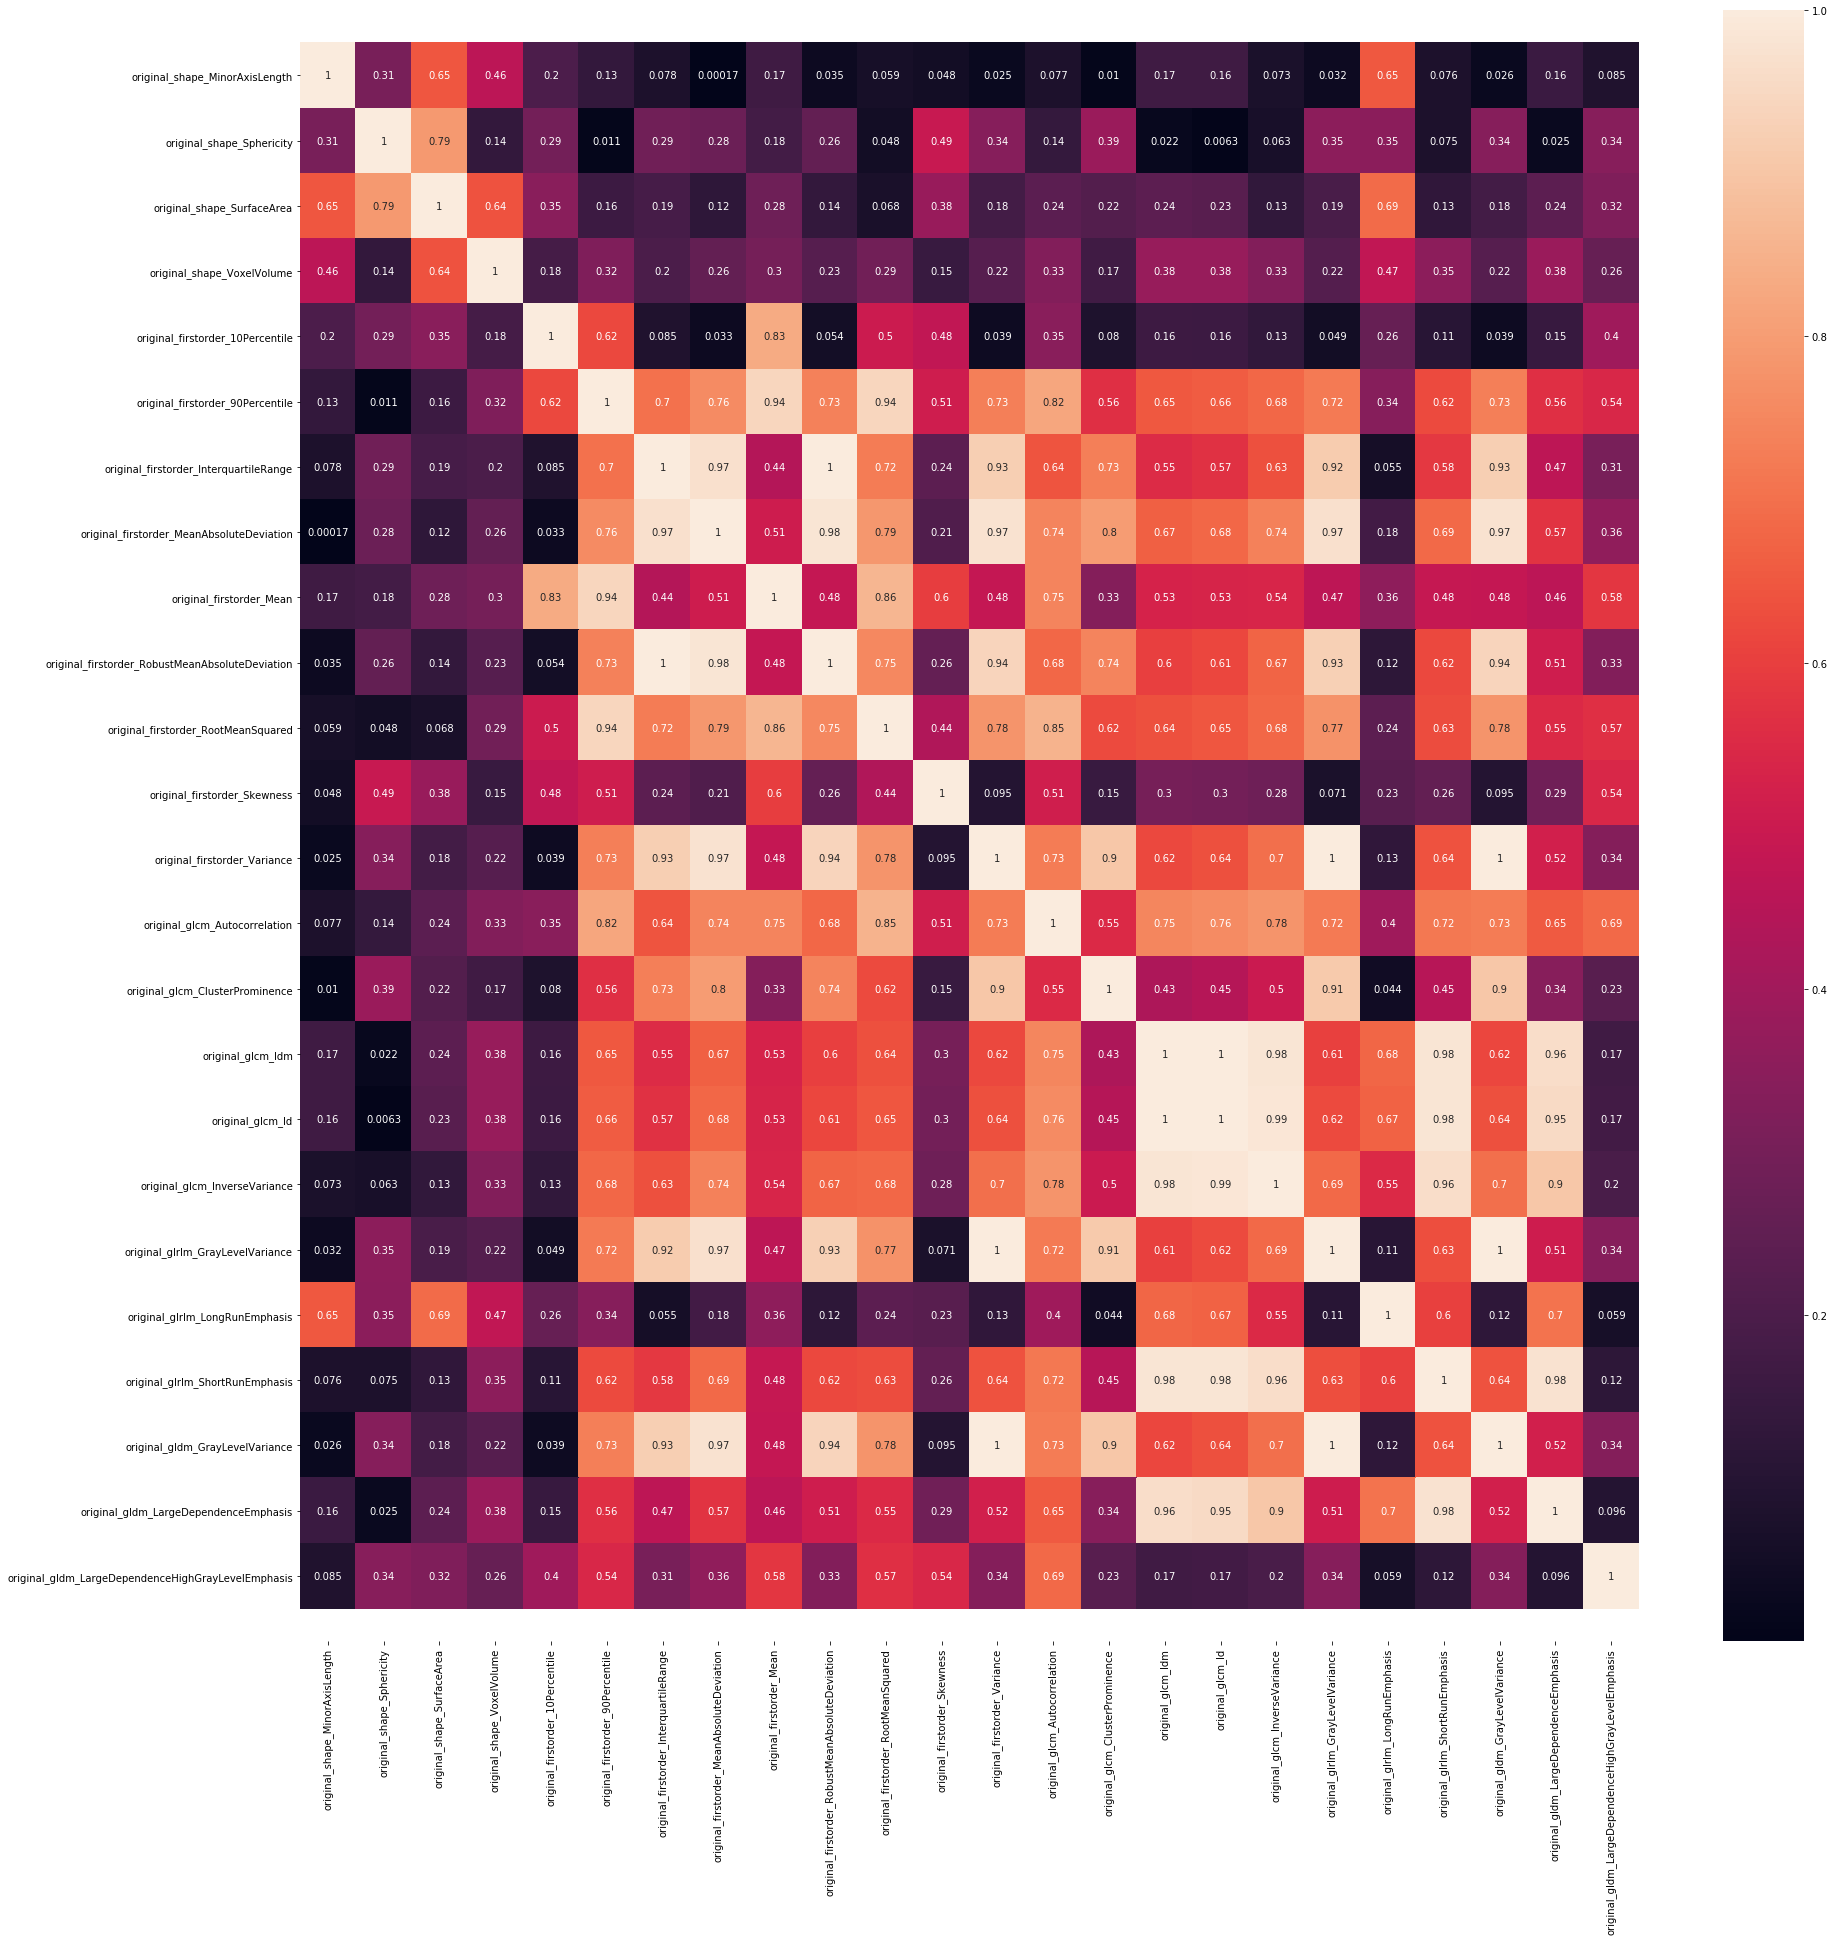

(111, 24)
(111, 14)


In [4]:
# corrleation analysis to eliminate one of the highly correlated features 

feature = pd.DataFrame(feature)

imp_feat = feature

f = plt.subplots(figsize=(30,30))
corr_mat = imp_feat.corr().abs()
ax = sn.heatmap(corr_mat,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
print(imp_feat.shape)

col_corr = set() # Set of all the names of deleted columns
threshold = 0.9
corr_matrix = imp_feat.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
            colname = corr_matrix.columns[i] # getting the name of column
            col_corr.add(colname)
            if colname in imp_feat.columns:
                del imp_feat[colname] # deleting the column from the dataset
                
feature = imp_feat
print(feature.shape)

In [132]:
# Train and test sets split 

name = reader.fieldnames[1:]
feature_train, feature_test, target_train, target_test = train_test_split(feature,target,test_size=0.25,random_state=3)

In [133]:
# Data normalization

scaler = StandardScaler()
encoder = LabelEncoder()
feature_train = scaler.fit_transform(feature_train)
feature_test = scaler.fit_transform(feature_test)
encoder.fit(target_train)
encoder.fit(target_test)
target_train = encoder.fit_transform(target_train)
target_test = encoder.fit_transform(target_test)

In [134]:
# For balancing unbalanced class (plot_2d_space)

def plot_2d_space(X, y, label='Classes'):  
    
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

9 new random picked points


/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


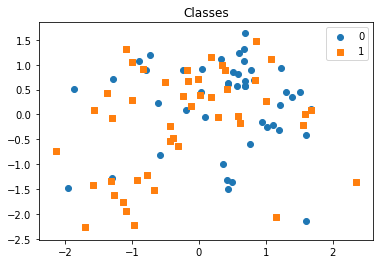

In [135]:
# For balancing unbalanced class (code)

# ros = RandomOverSampler()
ros = SMOTE(ratio='minority')
# ros = RandomUnderSampler(return_indices=True)
# ros = ClusterCentroids(ratio={0:10})
# ros = TomekLinks(return_indices=True, ratio='majority')

feature_train_ros, target_train_ros = ros.fit_sample(feature_train, target_train)
print(feature_train_ros.shape[0] - feature_train.shape[0], 'new random picked points')
# print('Removed indexes:', id_ros)

feature_train = feature_train_ros
target_train = target_train_ros

plot_2d_space(feature_train, target_train)

In [136]:
# Prinpal Component Analysis (PCA)

pca = PCA(0.95)
pca.fit(feature_train)
pca.fit(feature_test)
imp_feature_train = pca.transform(feature_train)
imp_feature_test = pca.transform(feature_test)

n_pcs = pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [name[most_important[i]] for i in range(n_pcs)]
variance_ratios = [pca.explained_variance_ratio_[i] for i in range(n_pcs)]
# most_important_ind = [imp_feature_ind[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())
df['variance ratio'] = variance_ratios
print(df)

feature_train = imp_feature_train
feature_test = imp_feature_test

     0                                          1  variance ratio
0  PC0        original_firstorder_RootMeanSquared        0.426445
1  PC1     original_firstorder_InterquartileRange        0.308912
2  PC2  original_firstorder_MeanAbsoluteDeviation        0.089156
3  PC3           original_firstorder_10Percentile        0.058335
4  PC4               original_firstorder_Variance        0.056412
5  PC5                 original_shape_VoxelVolume        0.025490


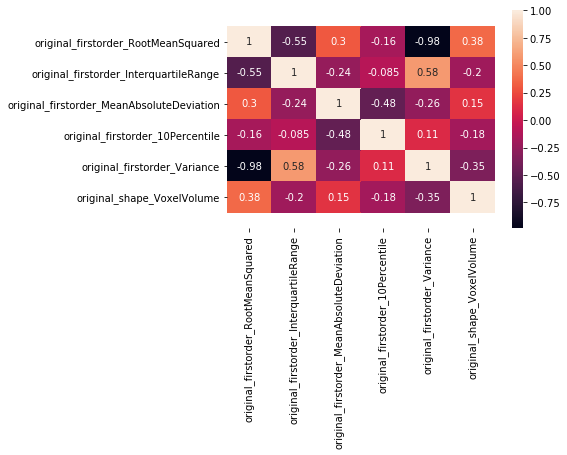

In [137]:
# Prinpal Component Analysis (PCA): correlation matrix after PCA

header = []
col = []
for i in range(pca.components_.shape[0]):
    col.append(feature.iloc[:,most_important[i]])
    header.append(name[most_important[i]])

col = np.array(col)
col = np.transpose(col)
frame = pd.DataFrame(col, columns = header)

ax = sn.heatmap(frame.corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [138]:
# model construction using selected features: RF 

model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=10)
model.fit(feature_train,target_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

In [45]:
# RF: determine parameters

n_estimators = [int(x) for x in np.linspace(start = 0, stop = 200, num = 11)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(0, 300, num = 11)]
max_depth.append(None)
min_samples_split = [1,2,4]
min_samples_leaf = [1,2,4]
bootstrap = [True]
oob_score = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score}

print(random_grid)

{'n_estimators': [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, None], 'min_samples_split': [1, 2, 4], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True], 'oob_score': [True]}


In [46]:
# RF: use random grid to search for best hyperparameters

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = 1)

rf_random.fit(feature_train,target_train)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estima

[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=270, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=270, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  oob_score=True, n_estimators=180, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=180, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=180, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_sa

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  Fi

[CV]  oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=120, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=120, bootstrap=True 
[CV]  oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=120, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=60,

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  oob_score=True, n_estimators=120, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=120, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=120, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=120, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=160, min_s

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=270, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=270, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=270, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=270, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=120, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=120, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=120, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=120, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=120, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=120, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=120, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  oob_score=True, n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueE

[CV]  oob_score=True, n_estimators=60, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=180, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=180, min_

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=210, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=210, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=210, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=210, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=240, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=240, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=240, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=240, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=240, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=240, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=240, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_s

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80,

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=140, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=140, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=140, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=140, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=140, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=140, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=140, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=0, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=240, bootstrap=True 
[CV]  oob_score=True, n_estimators=0, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=240, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=0, min_sam

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_s

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60,

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  oob_score=True, n_estimators=20, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=20, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=20, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=20, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_samples_s

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=140, min_s

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 


/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=180, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=80, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=80, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=0, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_s

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=150, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=150, bootstrap=True 
[CV]  oob_score=True, n_estimators=200, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=150, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=auto, max_depth=150, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=auto, max_depth=150, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=auto, max_depth=150, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=auto, max_depth=150, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=auto, max_depth=150, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=auto, max_depth=150, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=4, max_features=auto, max_depth=150, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True 


/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=160, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=210, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimat

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=40, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=240, bootstrap=True 
[CV]  oob_score=True, n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=240, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=1, min_samples_leaf=2, max_features=sqrt, max_depth=270, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimator

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=210, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=210, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=210, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True 
[CV]  oob_score=True, n_estimators=100, min_samples_split=1, min_samples_leaf=1, max_features=auto, max_depth=270, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=180, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=180, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimator

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  oob_score=True, n_estimators=120, min_samples_split=1, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=120

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  oob_score=True, n_estimators=60, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=80, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=150, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=150, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=80, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=150, bootstrap=True 
[CV]  oob_score=True, n_estimators=80, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=150, bootstrap=True, total=   0.1s
[CV] oob_score=True, n_estimators=

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=20, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=20, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=20, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=20, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=20, min_sa

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=160, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=160, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=160, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=160, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  oob_score=True, n_estimators=160, min_samples_split=1, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=40, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greate

[CV]  oob_score=True, n_estimators=40, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=40, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=40, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  oob_score=True, n_estimators=40, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.0s
[CV] oob_score=True, n_estimators=140, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=240, bootstrap=True 
[CV]  oob_score=True, n_estimators=140, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=240, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=140, m

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   42.5s finished


{'oob_score': True,
 'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [47]:
def evaluate(model, feature_test,target_test):
    predictions = model.predict(feature_test)
    errors = abs(predictions - target_test)
    accuracy = (len(errors)-np.count_nonzero(errors))/(len(errors))
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [48]:
# RF: 

pred_train = model.predict(feature_train)
errors = abs(pred_train - target_train)
accuracy = (len(errors)-np.count_nonzero(errors))/(len(errors))
print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Model Performance
Average Error: 0.0000 degrees.
Accuracy = 1.00%.


In [16]:
# RF: evaluate performance of random grid 

base_model = RandomForestClassifier(n_estimators = 100, random_state = 10)
base_model.fit(feature_train,target_train)
base_accuracy = evaluate(base_model, feature_test, target_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, feature_test, target_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.3214 degrees.
Accuracy = 0.68%.
Model Performance
Average Error: 0.3571 degrees.
Accuracy = 0.64%.
Improvement of -5.26%.


In [17]:
# RF: Create a parameter grid based on the results from random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [int(x) for x in np.linspace(0, 300, num = 11)],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,4],
    'n_estimators': [int(x) for x in np.linspace(start = 0, stop = 200, num = 11)],
    'oob_score': [True]}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 2)

In [18]:
# RF: Fit the grid search to the data

grid_search.fit(feature_train,target_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, feature_test, target_test)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 5 folds for each of 484 candidates, totalling 2420 fits
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=0, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=0, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=0, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=0, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=0, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=0, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=0, oob_score=True 
[CV]  boo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. De

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_va

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=0, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=0, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=0, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=0, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=0, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=0, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=180, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=180, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=180, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sq

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=20, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=80, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=120, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=140, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=160, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=160, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=180, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=180, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=180, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_featur

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: F

[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True 
[CV]  bootstrap=True, max_depth=0, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=30, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=60, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=90, max_featu

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=120, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=150, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=180, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=180, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=210, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=210, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=240, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=240, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=240, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=270, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=270, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=270, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, m

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_sele

[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.1s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True 
[CV]  bootstrap=True, max_depth=300, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=40, oob_score=True, total=   0.0s
[CV] bootstrap=True, max_depth=300, m

[Parallel(n_jobs=1)]: Done 2420 out of 2420 | elapsed:  4.5min finished


In [139]:
# RF: cross validation and result display using the model other than lasso 

model = model

cv = 5
loo = LeaveOneOut()
loo.get_n_splits(feature_train)
scv = []
for train_idx, test_idx in loo.split(feature_train):
    model.fit(feature_train[train_idx,:], target_train[train_idx])
    s = model.score(feature_train[test_idx,:], target_train[test_idx])
    scv.append(s)
scores_loo = cross_val_score(model, feature_train, target_train, cv=cv) 

# kfold = KFold(3, shuffle=True, random_state=5)
# scores_kfold = cross_val_score(model, feature_train, target_train, cv=cv) 

cvprediction = cross_val_predict(model, feature_train, target_train, cv=cv, method = 'predict_proba')
predicted = abs(cvprediction[:,1])

for i in range(predicted.shape[0]):
    if predicted[i] > 1.0: 
        predicted[i] = 1
    if predicted[i] <= -1.0:
        predicted[i] = 0
        
accuracy = accuracy_score(target_train,predicted.round())

tn_train, fp_train, fn_train, tp_train = confusion_matrix(target_train, abs(predicted.round())).ravel()
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)
auctraining = roc_auc_score(target_train, cvprediction[:,1])


# results based on cross-validation 
print("Classification accuracy on training set after 3-fold cross validation: {:2f}".format(accuracy))
print("Sensitivity on training set: {:2f}".format(sensitivity_train))
print("Specificity on training set: {:2f}".format(specificity_train))

# results without cross-validation 
target_train_pred = model.predict_proba(feature_train)
target_test_pred = model.predict_proba(feature_test)
asall_test = accuracy_score(target_test, target_test_pred[:,1].round())
auctest = roc_auc_score(target_test, target_test_pred[:,1])
predicted_test = target_test_pred[:,1].round()

for i in range(predicted_test.shape[0]):
    if predicted_test[i] > 1.0: 
        predicted_test[i] = 1
    if predicted_test[i] <= -1.0:
        predicted_test[i] = 0

tn_test, fp_test, fn_test, tp_test = confusion_matrix(target_test, abs(predicted_test)).ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)


print("Classification accuracy on test set: {:2f}".format(asall_test))
print("Sensitivity on test set: {:2f}".format(sensitivity_test))
print("Specificity on test set: {:2f}".format(specificity_test))
print("Area under the ROC curve (training): {:2f}".format(auctraining))
print("Area under the ROC curve (test): {:2f}".format(auctest))

Classification accuracy on training set after 3-fold cross validation: 0.663043
Sensitivity on training set: 0.673913
Specificity on training set: 0.652174
Classification accuracy on test set: 0.678571
Sensitivity on test set: 0.625000
Specificity on test set: 0.750000
Area under the ROC curve (training): 0.697306
Area under the ROC curve (test): 0.729167
